In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
import os
import pretrainedmodels
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from fastai.callbacks import *
np.random.seed(0)

# Data import

In [3]:
IMG_PATH = DATA_PATH/'higgsml'

In [4]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,gen_target,gen_weight
0,0,120.281,40.031000,87.237,72.170,0.000,0.000,0.00,2.001,2.070999,...,1.000000e+00,73.837,0.346,2.888,0.000,0.000,0.000,7.383700e+01,1,0.000048
1,1,105.942,44.081000,65.518,30.699,0.000,0.000,0.00,2.736,30.699000,...,-1.611709e-08,0.000,0.000,0.000,0.000,0.000,0.000,9.804058e-07,0,0.000153
2,2,137.252,3.769001,80.249,138.691,7.055,1841.646,-12.39,1.606,29.180000,...,2.000000e+00,69.867,-3.758,2.923,41.963,3.297,-3.038,1.118300e+02,1,0.000027
3,3,153.137,40.298000,102.665,19.563,0.000,0.000,0.00,3.117,19.563000,...,-1.611709e-08,0.000,0.000,0.000,0.000,0.000,0.000,9.804058e-07,1,0.000335
4,4,122.495,33.615000,97.282,268.633,0.432,228.553,4.27,1.199,53.696000,...,2.000000e+00,339.315,1.861,-2.051,37.374,2.294,0.299,3.766890e+02,1,0.000027


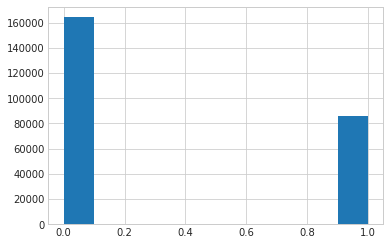

In [5]:
train_df.gen_target.hist()

In [6]:
len(train_df[train_df.gen_target==0])/len(train_df), len(train_df[train_df.gen_target==1])/len(train_df)

(0.657332, 0.342668)

In [7]:
size = 224

In [8]:
data = ImageDataBunch.from_df(df=train_df, label_col='gen_target', fn_col='image_name',
                              bs=20, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=IMG_PATH/'images', folder='train', suffix='.png').normalize(imagenet_stats)

In [9]:
data

ImageDataBunch;

Train: LabelList (200000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,1,1,1
Path: ../data/higgsml/images;

Valid: LabelList (50000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,1,0,0
Path: ../data/higgsml/images;

Test: None

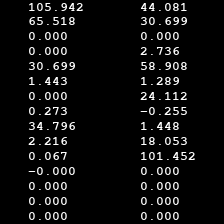

In [10]:
data.train_ds[0][0]

# Model training

In [11]:
def se_resnet154(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.senet154(pretrained=pretrained)
    return model

In [12]:
learn = cnn_learner(data, se_resnet154, pretrained=True, cut=-3,
                    split_on=lambda m: (m[0][3], m[1]), metrics=error_rate, lin_ftrs=[], bn_final=False, ps=[0]
                )

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU(inplace)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEBottleneck(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [14]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


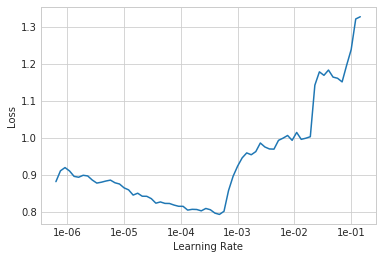

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,2e-4),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate', name='best', mode='min')])

epoch,train_loss,valid_loss,error_rate,time
0,0.446493,0.414673,0.187040,1:53:09
1,0.415049,0.378068,0.164560,1:52:34
2,0.372774,0.370402,0.165040,1:54:00
3,0.242812,0.422550,0.176200,1:52:17


Better model found at epoch 0 with error_rate value: 0.18704000115394592.
Better model found at epoch 1 with error_rate value: 0.164560005068779.


In [17]:
learn.save('stage-1')

In [19]:
learn.load('best');

In [20]:
learn.export()

# Inference

## Test

In [12]:
test_df = pd.read_csv(IMG_PATH/'test.csv'); len(test_df); test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,gen_target,gen_weight,private
0,0,106.398,67.490000,87.949,49.994,0.0,0.0,0.0,2.048,2.678999,...,47.575,-0.553,-0.849,0.0,0.0,0.0,4.757500e+01,0,1.421938,1
1,1,89.921,75.566000,73.543,69.708,0.0,0.0,0.0,2.001,25.345000,...,45.078,2.571,-1.255,0.0,0.0,0.0,4.507800e+01,0,1.269061,1
2,2,140.991,4.050999,93.500,110.986,0.0,0.0,0.0,2.270,5.396000,...,116.371,-1.442,-0.487,0.0,0.0,0.0,1.163710e+02,1,0.000840,1
3,3,78.985,44.820000,51.597,43.051,0.0,0.0,0.0,2.251,21.792000,...,60.787,-0.539,-2.199,0.0,0.0,0.0,6.078700e+01,0,4.969177,0
4,4,108.035,29.078000,82.979,2.457,0.0,0.0,0.0,2.922,2.456999,...,0.000,0.000,0.000,0.0,0.0,0.0,9.804058e-07,1,0.046987,0


In [13]:
test_lst = ImageList.from_df(test_df, IMG_PATH/'images', folder='test', suffix='.png')

In [14]:
learn = load_learner(IMG_PATH/'images', test=test_lst)

In [15]:
%%time
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

CPU times: user 4h 7min 22s, sys: 4h 8min 3s, total: 8h 15min 25s
Wall time: 1h 5min 9s


In [16]:
test_df['pred'] = to_np(multiclass2binary(preds))

In [17]:
test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,gen_target,gen_weight,private,pred
0,0,106.398,67.490000,87.949,49.994,0.0,0.0,0.0,2.048,2.678999,...,-0.553,-0.849,0.0,0.0,0.0,4.757500e+01,0,1.421938,1,0.207496
1,1,89.921,75.566000,73.543,69.708,0.0,0.0,0.0,2.001,25.345000,...,2.571,-1.255,0.0,0.0,0.0,4.507800e+01,0,1.269061,1,0.152142
2,2,140.991,4.050999,93.500,110.986,0.0,0.0,0.0,2.270,5.396000,...,-1.442,-0.487,0.0,0.0,0.0,1.163710e+02,1,0.000840,1,0.745235
3,3,78.985,44.820000,51.597,43.051,0.0,0.0,0.0,2.251,21.792000,...,-0.539,-2.199,0.0,0.0,0.0,6.078700e+01,0,4.969177,0,0.181135
4,4,108.035,29.078000,82.979,2.457,0.0,0.0,0.0,2.922,2.456999,...,0.000,0.000,0.0,0.0,0.0,9.804058e-07,1,0.046987,0,0.653041


In [20]:
test_df.to_csv('higgsml1_test.csv')

### AMS on public & private for 0.5  cut

In [19]:
score_test_df(test_df, 0.5)

Public:Private AMS: 2.8299296922621857 : 2.836586306772915


(2.8299296922621857, 2.836586306772915)

### Maximum AMS on public and private

In [21]:
from lumin.evaluation.ams import *
from sklearn.model_selection import StratifiedKFold

In [22]:
ams_scan_quick(test_df[test_df.private==0], br=10), ams_scan_quick(test_df[test_df.private==1], br=10)

((3.1966668119593744, 0.813427209854126),
 (3.25004969853627, 0.8072656989097595))

### Double lumi hypothesis:
Compute AMS on the entire testing dataset with no split on public-private

In [27]:
accept = (test_df.pred >= 0.5)
signal = (test_df.gen_target == 1)
bkg = (test_df.gen_target == 0)
calc_ams(np.sum(test_df.loc[accept & signal, 'gen_weight']),
         np.sum(test_df.loc[accept & bkg, 'gen_weight']))

4.0068259736645535